In [7]:
import numpy as np
import cv2
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 30, 15

def mouse_handler(event, x, y, flags, data) :
    
    if event == cv2.EVENT_LBUTTONDOWN :
        cv2.circle(data['im'], (x,y),3, (0,0,255), 5, 16);
        cv2.imshow("Image", data['im']);
        if len(data['points']) < 4 :
            data['points'].append([x,y])


def get_four_points(im):
    
    # Set up data to send to mouse handler
    data = {}
    data['im'] = im.copy()
    data['points'] = []
    
    #Set the callback function for any mouse event
    cv2.imshow("Image",im)
    cv2.setMouseCallback("Image", mouse_handler, data)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    # Convert array to np.array
    points = np.vstack(data['points']).astype(float)
    
    return points

def to_mtx(img):
    H,V,C = img.shape
    mtr = np.zeros((V,H,C), dtype='int')
    for i in range(img.shape[0]):
        mtr[:,i] = img[i]
    
    return mtr

def to_img(mtr):
    V,H,C = mtr.shape
    img = np.zeros((H,V,C), dtype='int')
    for i in range(mtr.shape[0]):
        img[:,i] = mtr[i]
        
    return img

def warpPerspective(img, M, dsize):
    mtr = to_mtx(img)
    R,C = dsize
    dst = np.zeros((R,C,mtr.shape[2]))
    for i in range(mtr.shape[0]):
        for j in range(mtr.shape[1]):
            res = np.dot(M, [i,j,1])
            i2,j2,_ = (res / res[2] + 0.5).astype(int)
            if i2 >= 0 and i2 < R:
                if j2 >= 0 and j2 < C:
                    dst[i2,j2] = mtr[i,j]
    
    return to_img(dst)

def get_coef(a, b, n):
    res = []
    b = [b[0], b[1], 1]
    dim = 3
    for i in range(dim):
        curr = [0] * dim * 4
        curr[i] = a[0]
        curr[dim + i] = a[1]
        curr[2*dim + i] = 1 if i != 2 else 0
        
        curr[3*dim + n - 1] = -b[i]
        res.append(curr)
    return res

def getPerspectiveTransform(pts1, pts2):
    A = []
    plen = len(pts1)
    for i in range(plen):
        A += get_coef(pts1[i], pts2[i], i)
        
    B = [0, 0, -1] * plen
    print(A)
    print(B)
    C = np.linalg.solve(A, B)
    # First 8 elements of C now contains a flattened transformation matrix M(the 9-th element is always set to 1)
    # while the last 4 elements are scaling factors specific for each example. Since we are only interested
    # in M, we will extract only its values below
    res = np.ones(9)
    res[:8] = C.flatten()[:8]
    return res.reshape(3,-1).T

In [2]:
src = cv2.imread("1.png")
dst = cv2.imread("H_output.png")
H = np.array([
    [8.7976964e-01,   3.1245438e-01,  -3.9430589e+01],
    [-1.8389418e-01,   9.3847198e-01,   1.5315784e+02],
    [1.9641425e-04,  -1.6015275e-05,   1.0000000e+00]])

In [4]:
pts_src = get_four_points(src)
pts_dst = get_four_points(dst)

H_calc = getPerspectiveTransform(pts_src, pts_dst)

[[124.0, 0, 0, 605.0, 0, 0, 1, 0, -253.0, 0, 0, 0], [0, 124.0, 0, 0, 605.0, 0, 0, 1, -690.0, 0, 0, 0], [0, 0, 124.0, 0, 0, 605.0, 0, 0, -1, 0, 0, 0], [123.0, 0, 0, 269.0, 0, 0, 1, 0, 0, -149.0, 0, 0], [0, 123.0, 0, 0, 269.0, 0, 0, 1, 0, -378.0, 0, 0], [0, 0, 123.0, 0, 0, 269.0, 0, 0, 0, -1, 0, 0], [458.0, 0, 0, 269.0, 0, 0, 1, 0, 0, 0, -412.0, 0], [0, 458.0, 0, 0, 269.0, 0, 0, 1, 0, 0, -294.0, 0], [0, 0, 458.0, 0, 0, 269.0, 0, 0, 0, 0, -1, 0], [458.0, 0, 0, 608.0, 0, 0, 1, 0, 0, 0, 0, -512.0], [0, 458.0, 0, 0, 608.0, 0, 0, 1, 0, 0, 0, -592.0], [0, 0, 458.0, 0, 0, 608.0, 0, 0, 0, 0, 0, -1]]
[0, 0, -1, 0, 0, -1, 0, 0, -1, 0, 0, -1]


In [5]:
destination_size = (src.shape[1],src.shape[0])
re_dst = warpPerspective(src, H_calc, destination_size)

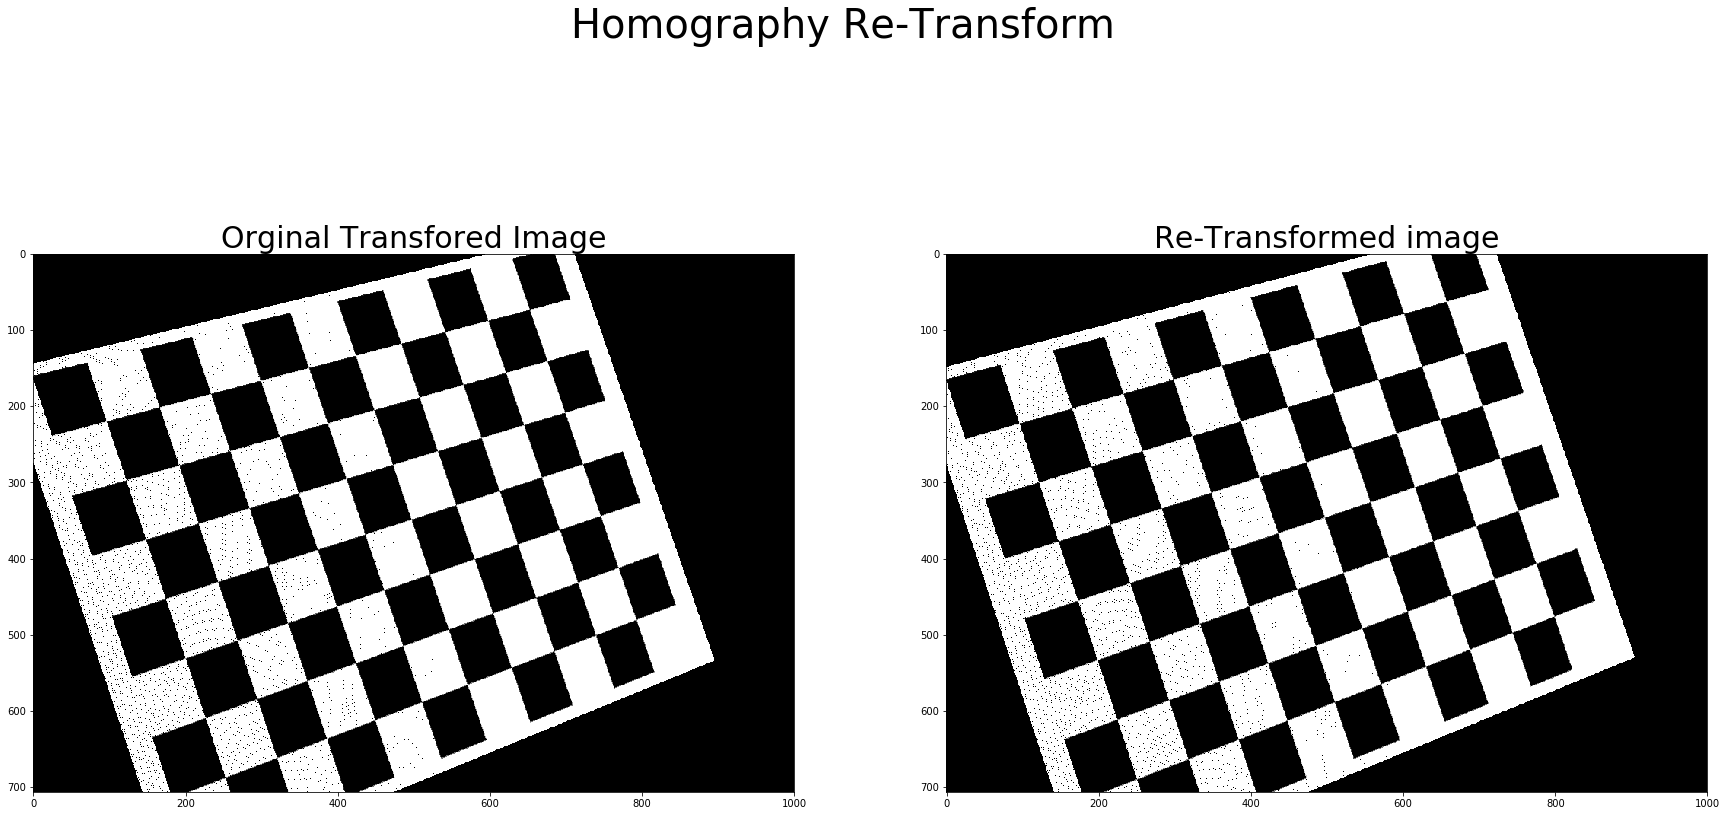

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Homography Re-Transform', fontsize=40)
ax1.set_title('Orginal Transfored Image', fontsize=30)
im1 = ax1.imshow(dst)
ax2.set_title('Re-Transformed image', fontsize=30)
im2 = ax2.imshow(re_dst)
plt.show()